# ОСНОВНЫЕ ПРИНЦИПЫ MPC

Model Predictive Control (MPC) - это продвинутый метод управления, который использует модель системы для прогнозирования её будущего поведения и оптимизации управляющих воздействий с учётом ограничений.

Ключевые особенности:

Использует модель системы для прогнозирования

Решает задачу оптимизации на конечном горизонте

Учитывает ограничения на состояния и управления

Применяет принцип "перекатывающегося горизонта"

Работает в режиме обратной связи

Ключевая философская идея: MPC имитирует человеческое мышление при управлении сложными системами. Когда мы ведем автомобиль, мы:

Смотрим вперед (прогноз)

Планируем траекторию (оптимизация)

Корректируем план по мере движения (обратная связь)


🚗 ДЕМОНСТРАЦИЯ: Управление машинкой с помощью MPC 🚗
Начинаем движение к гаражу...


C:\Users\David\AppData\Local\Temp\ipykernel_28652\3830007980.py:177: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\David\AppData\Local\Temp\ipykernel_28652\3830007980.py:177: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\David\AppData\Local\Temp\ipykernel_28652\3830007980.py:177: UserWarning: Glyph 127899 (\N{CONTROL KNOBS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


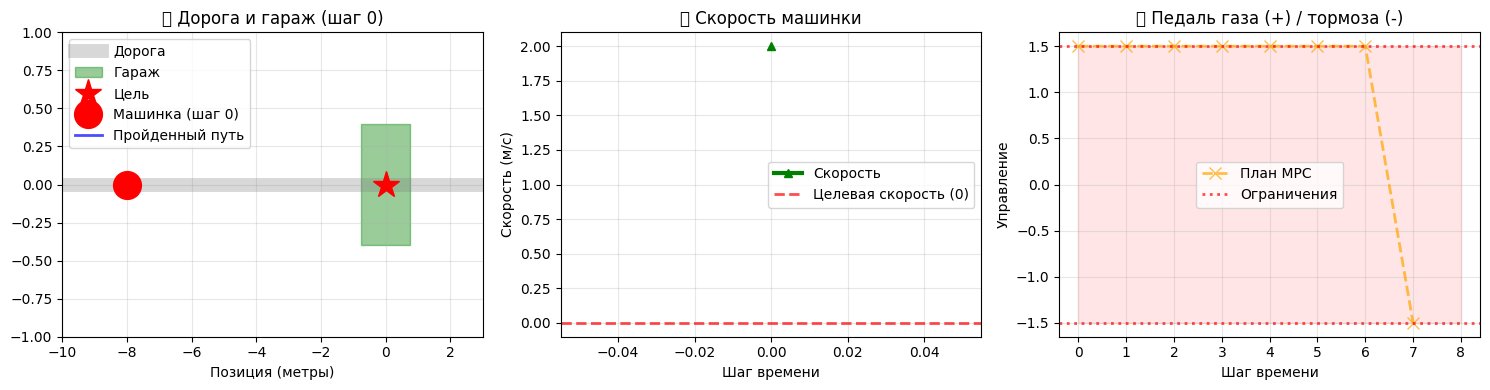

Шаг 0: До гаража 8.00 м, Скорость 2.00 м/с, Управление 1.50


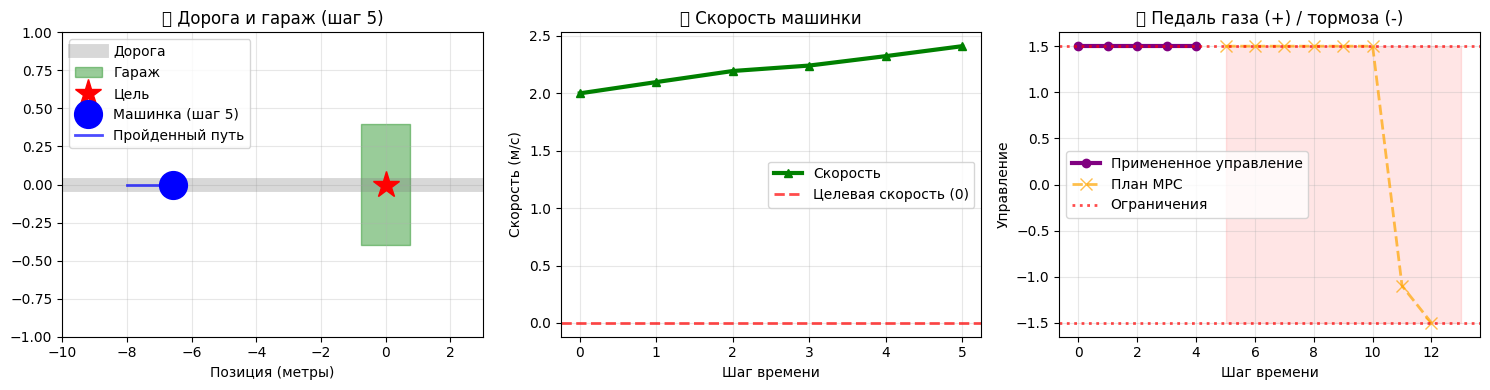

Шаг 5: До гаража 6.58 м, Скорость 2.41 м/с, Управление 1.50


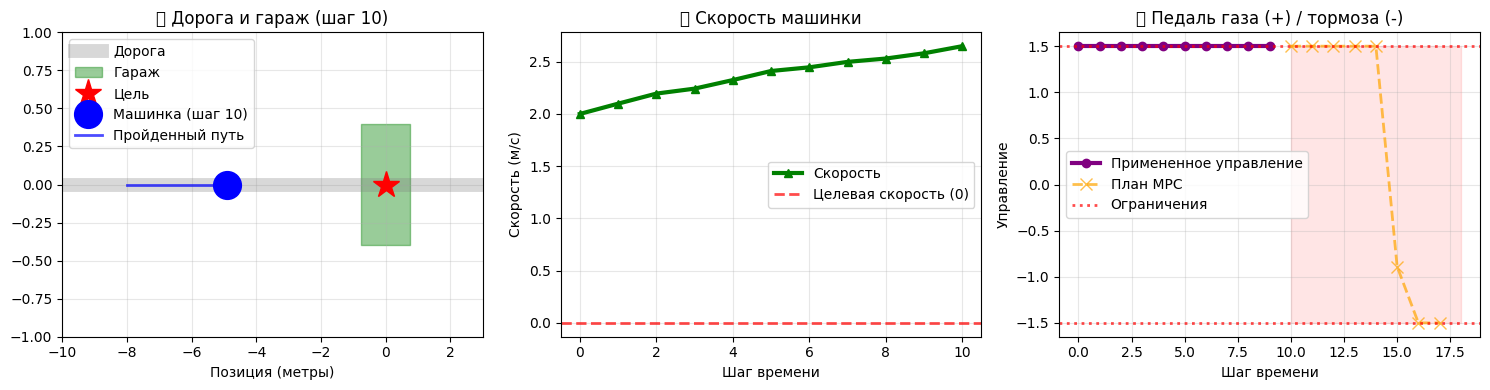

Шаг 10: До гаража 4.91 м, Скорость 2.65 м/с, Управление 1.50


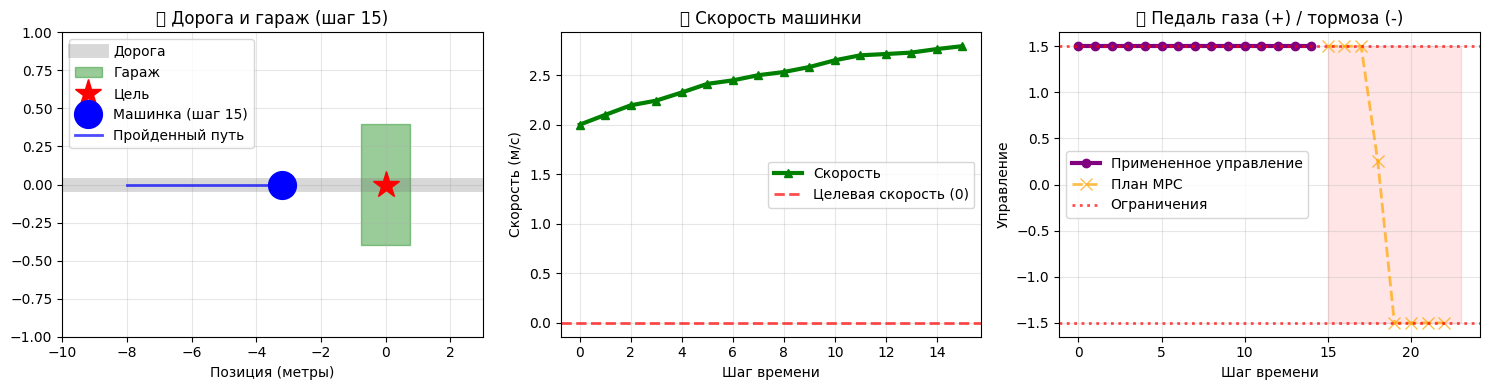

Шаг 15: До гаража 3.22 м, Скорость 2.79 м/с, Управление 1.50


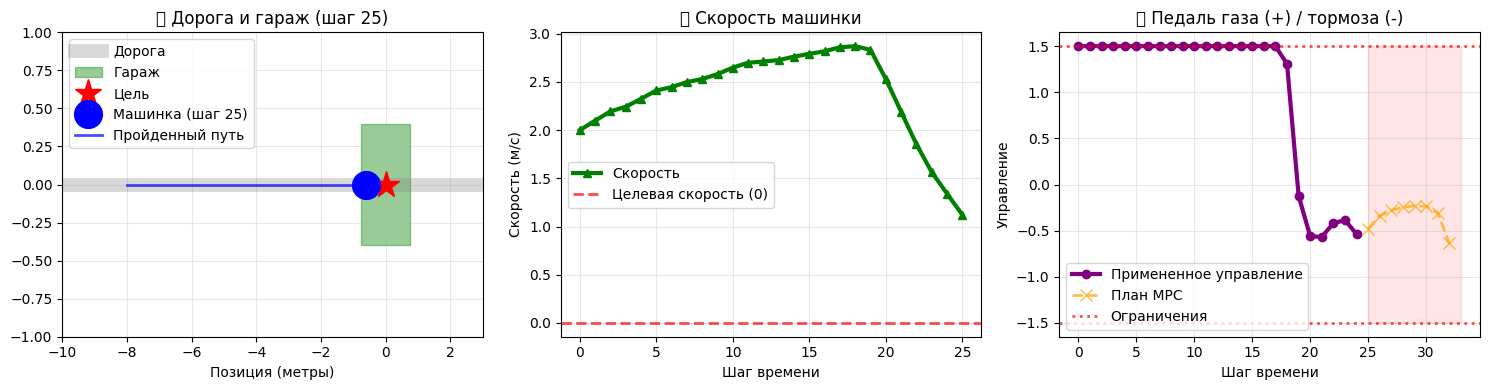

Шаг 25: До гаража 0.62 м, Скорость 1.12 м/с, Управление -0.48


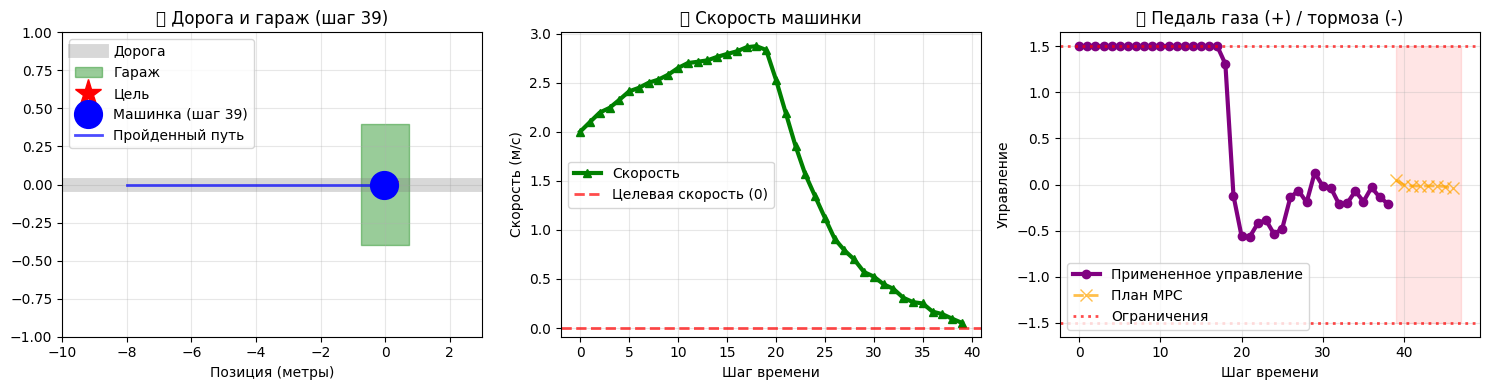

Шаг 39: До гаража 0.04 м, Скорость 0.05 м/с, Управление 0.04


C:\Users\David\AppData\Local\Temp\ipykernel_28652\3830007980.py:239: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\David\AppData\Local\Temp\ipykernel_28652\3830007980.py:239: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\David\AppData\Local\Temp\ipykernel_28652\3830007980.py:239: UserWarning: Glyph 127899 (\N{CONTROL KNOBS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\David\AppData\Local\Temp\ipykernel_28652\3830007980.py:239: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


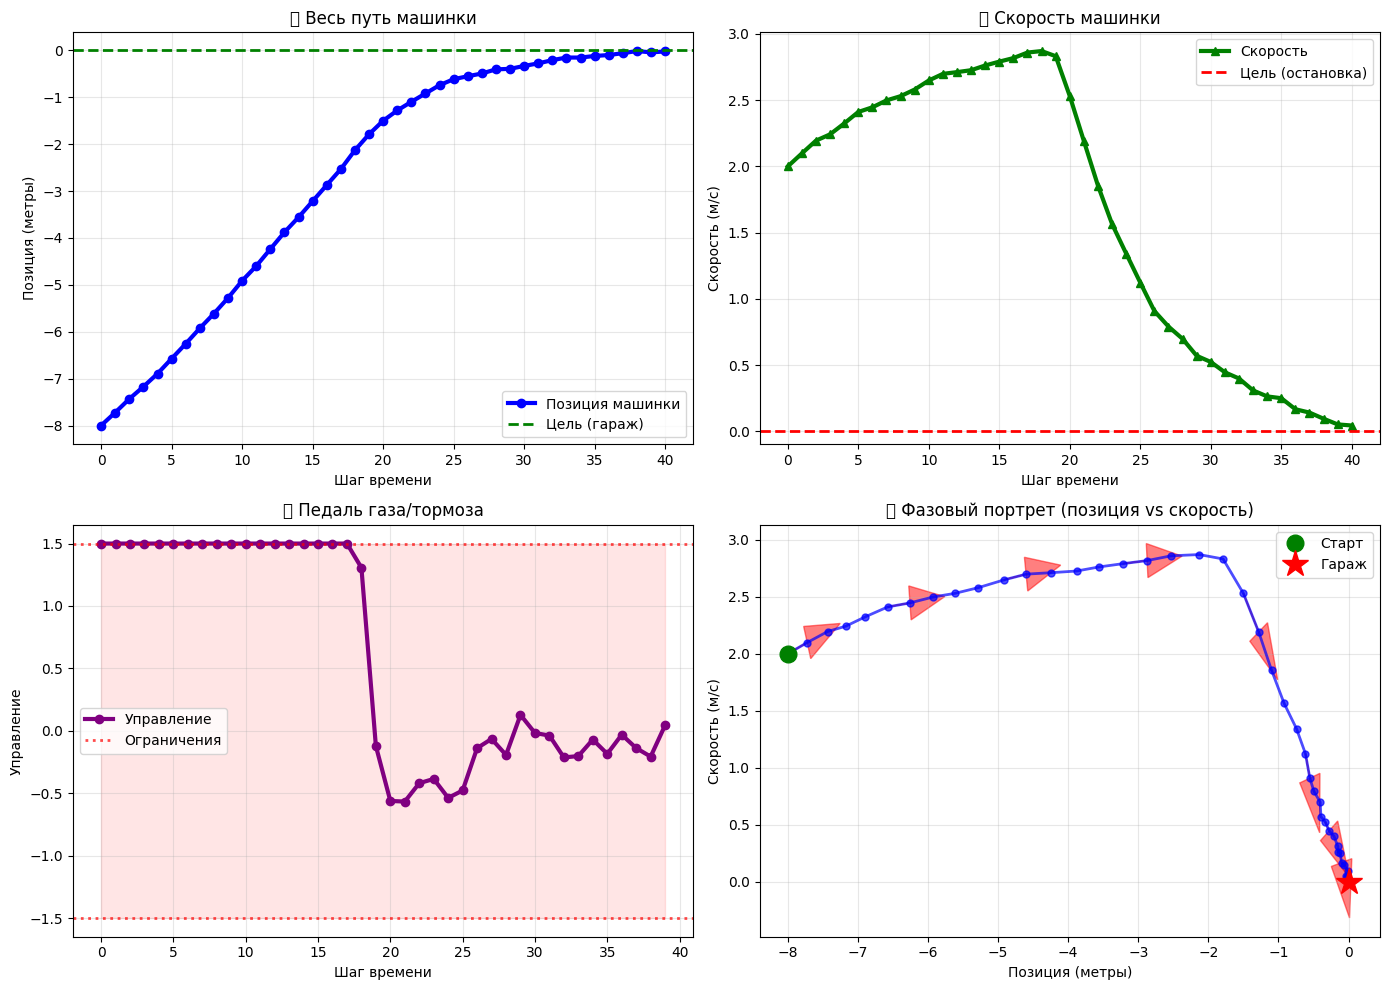


🎯 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:
🏁 Финальная позиция: -0.023 м (цель: 0 м)
📏 Финальная скорость: 0.044 м/с (цель: 0 м/с)
🎯 Точность попадания: 0.0498
⛽ Средний 'расход топлива': 0.826
🕒 Время достижения цели: 40 шагов
✅ УСПЕХ: Машинка успешно заехала в гараж! 🎉


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

print("🚗 ДЕМОНСТРАЦИЯ: Управление машинкой с помощью MPC 🚗")

class CarMPC:
    """MPC-контроллер для управления машинкой"""
    
    def __init__(self, horizon=5, u_min=-1, u_max=1):
        # Параметры машинки: [положение, скорость]
        self.A = np.array([[1, 0.1],  # позиция + скорость*время
                          [0, 0.9]])  # скорость с небольшим трением
        self.B = np.array([[0.05],    # ускорение влияет на позицию
                          [0.2]])     # и на скорость
        
        # Весовые коэффициенты
        self.Q = np.diag([10, 5])     # важнее попасть в цель, чем иметь нулевую скорость
        self.R = 0.1 * np.eye(1)      # небольшой штраф на управление
        self.P = 20 * np.eye(2)       # терминальный штраф
        
        self.N = horizon
        self.u_min = u_min
        self.u_max = u_max
        self.n = self.A.shape[0]  # размерность состояния
        self.m = self.B.shape[1]  # размерность управления
    
    def cost_function(self, U_flat, x0, x_ref):
        """Целевая функция - минимизировать ошибку и расход энергии"""
        U = U_flat.reshape(self.m, self.N)
        X = np.zeros((self.n, self.N + 1))
        X[:, 0] = x0
        
        cost = 0
        for k in range(self.N):
            X[:, k + 1] = self.A @ X[:, k] + self.B @ U[:, k]
            state_error = X[:, k] - x_ref
            cost += state_error.T @ self.Q @ state_error + U[:, k].T @ self.R @ U[:, k]
        
        terminal_error = X[:, self.N] - x_ref
        cost += terminal_error.T @ self.P @ terminal_error
        return cost
    
    def solve(self, x0, x_ref):
        """Решаем задачу оптимизации"""
        U0 = np.zeros(self.m * self.N)
        
        # Ограничения на управление
        bounds = []
        if self.u_min is not None and self.u_max is not None:
            for _ in range(self.N):
                bounds.append((self.u_min, self.u_max))
        
        result = minimize(
            fun=lambda U: self.cost_function(U, x0, x_ref),
            x0=U0,
            method='SLSQP',
            bounds=bounds,
            options={'maxiter': 500}
        )
        
        if result.success:
            U_opt = result.x.reshape(self.m, self.N)
            return U_opt[0, 0], U_opt
        else:
            # Если оптимизация не удалась, возвращаем нулевое управление
            return 0, np.zeros((self.m, self.N))

def car_simulation():
    """Симуляция движения машинки в гараж"""
    
    # Создаем MPC контроллер
    mpc = CarMPC(horizon=8, u_min=-1.5, u_max=1.5)
    
    # Начальные условия: машинка далеко от гаража, движется
    x0 = np.array([-8.0, 2.0])  # [позиция, скорость]
    x_garage = np.array([0.0, 0.0])  # цель: в гараже, остановилась
    
    # Параметры симуляции
    n_steps = 40
    positions = np.zeros(n_steps + 1)
    speeds = np.zeros(n_steps + 1)
    controls = np.zeros(n_steps)
    
    positions[0] = x0[0]
    speeds[0] = x0[1]
    
    print("Начинаем движение к гаражу...")
    
    # Основной цикл симуляции
    for k in range(n_steps):
        current_state = np.array([positions[k], speeds[k]])
        u_opt, u_sequence = mpc.solve(current_state, x_garage)
        
        controls[k] = u_opt
        
        # ИСПРАВЛЕНИЕ: Правильное обновление состояния
        # Умножаем матрицу A на текущее состояние
        state_update = mpc.A @ current_state
        # Добавляем влияние управления
        control_update = mpc.B.flatten() * u_opt
        # Суммируем и добавляем шум
        next_state = state_update + control_update + 0.02 * np.random.randn(2)
        
        positions[k + 1] = next_state[0]
        speeds[k + 1] = next_state[1]
        
        # Визуализация на ключевых шагах
        if k in [0, 5, 10, 15, 25, n_steps-1]:
            plot_car_situation(positions, speeds, controls, k, u_sequence, x_garage)
    
    # Финальная визуализация
    plot_final_results(positions, speeds, controls, x_garage)

def plot_car_situation(positions, speeds, controls, current_step, u_sequence, garage):
    """Визуализация текущей ситуации с машинкой"""
    plt.figure(figsize=(15, 4))
    
    # 1. График позиции машинки
    plt.subplot(1, 3, 1)
    
    # Рисуем дорогу
    road_y = 0
    plt.axhline(y=road_y, color='gray', linewidth=10, alpha=0.3, label='Дорога')
    
    # Рисуем гараж
    garage_width = 1.5
    plt.fill_between([-garage_width/2, garage_width/2], 
                    road_y-0.4, road_y+0.4, color='green', alpha=0.4, label='Гараж')
    plt.plot(0, road_y, 'r*', markersize=20, markeredgecolor='red', label='Цель')
    
    # Текущая позиция машинки
    current_pos = positions[current_step]
    car_color = 'red' if current_step == 0 else 'blue' if current_step < len(positions)-1 else 'purple'
    plt.plot(current_pos, road_y, 'o', color=car_color, markersize=20, label=f'Машинка (шаг {current_step})')
    
    # Пройденный путь
    plt.plot(positions[:current_step+1], np.zeros(current_step+1), 'b-', alpha=0.7, linewidth=2, label='Пройденный путь')
    
    plt.xlim(-10, 3)
    plt.ylim(-1, 1)
    plt.xlabel('Позиция (метры)')
    plt.title(f'🚗 Дорога и гараж (шаг {current_step})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. График скорости
    plt.subplot(1, 3, 2)
    plt.plot(range(current_step+1), speeds[:current_step+1], 'g^-', linewidth=3, markersize=6, label='Скорость')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.7, linewidth=2, label='Целевая скорость (0)')
    plt.xlabel('Шаг времени')
    plt.ylabel('Скорость (м/с)')
    plt.title('📈 Скорость машинки')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. График управления (педаль газа/тормоза)
    plt.subplot(1, 3, 3)
    if current_step > 0:
        plt.plot(range(current_step), controls[:current_step], 'purple', linewidth=3, marker='o', markersize=6, label='Примененное управление')
    
    # Планируемые управления
    future_steps = list(range(current_step, current_step + len(u_sequence.flatten())))
    plt.plot(future_steps, u_sequence.flatten(), 'orange', alpha=0.7, marker='x', 
             linestyle='--', linewidth=2, markersize=8, label='План MPC')
    
    plt.axhline(y=1.5, color='red', linestyle=':', alpha=0.7, linewidth=2, label='Ограничения')
    plt.axhline(y=-1.5, color='red', linestyle=':', alpha=0.7, linewidth=2)
    plt.fill_between([current_step, current_step + 8], -1.5, 1.5, alpha=0.1, color='red')
    
    plt.xlabel('Шаг времени')
    plt.ylabel('Управление')
    plt.title('🎛️ Педаль газа (+) / тормоза (-)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Вывод текущего статуса
    distance_to_garage = abs(positions[current_step])
    speed = speeds[current_step]
    print(f"Шаг {current_step}: До гаража {distance_to_garage:.2f} м, Скорость {speed:.2f} м/с, Управление {controls[current_step]:.2f}")

def plot_final_results(positions, speeds, controls, garage):
    """Финальные результаты"""
    plt.figure(figsize=(14, 10))
    
    # 1. Общая траектория
    plt.subplot(2, 2, 1)
    plt.plot(positions, 'bo-', linewidth=3, markersize=6, label='Позиция машинки')
    plt.axhline(y=garage[0], color='green', linestyle='--', linewidth=2, label='Цель (гараж)')
    plt.xlabel('Шаг времени')
    plt.ylabel('Позиция (метры)')
    plt.title('🚗 Весь путь машинки')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Скорость
    plt.subplot(2, 2, 2)
    plt.plot(speeds, 'g^-', linewidth=3, markersize=6, label='Скорость')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Цель (остановка)')
    plt.xlabel('Шаг времени')
    plt.ylabel('Скорость (м/с)')
    plt.title('📈 Скорость машинки')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Управление
    plt.subplot(2, 2, 3)
    plt.plot(controls, color='purple', linewidth=3, marker='o', markersize=6, label='Управление')
    plt.axhline(y=1.5, color='red', linestyle=':', alpha=0.7, linewidth=2, label='Ограничения')
    plt.axhline(y=-1.5, color='red', linestyle=':', alpha=0.7, linewidth=2)
    plt.fill_between(range(len(controls)), -1.5, 1.5, alpha=0.1, color='red')
    plt.xlabel('Шаг времени')
    plt.ylabel('Управление')
    plt.title('🎛️ Педаль газа/тормоза')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Фазовый портрет
    plt.subplot(2, 2, 4)
    plt.plot(positions, speeds, 'o-', linewidth=2, markersize=5, color='blue', alpha=0.7)
    plt.plot(positions[0], speeds[0], 'go', markersize=12, label='Старт')
    plt.plot(garage[0], garage[1], 'r*', markersize=20, label='Гараж')
    
    # Добавляем стрелки для направления движения
    for i in range(0, len(positions)-1, 5):
        plt.arrow(positions[i], speeds[i], 
                 positions[i+1]-positions[i], speeds[i+1]-speeds[i],
                 head_width=0.3, head_length=0.5, fc='red', ec='red', alpha=0.5)
    
    plt.xlabel('Позиция (метры)')
    plt.ylabel('Скорость (м/с)')
    plt.title('🔄 Фазовый портрет (позиция vs скорость)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Финальная статистика
    final_error = np.linalg.norm([positions[-1], speeds[-1]] - garage)
    avg_control = np.mean(np.abs(controls))
    
    print(f"\n{'='*50}")
    print("🎯 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
    print(f"{'='*50}")
    print(f"🏁 Финальная позиция: {positions[-1]:.3f} м (цель: 0 м)")
    print(f"📏 Финальная скорость: {speeds[-1]:.3f} м/с (цель: 0 м/с)")
    print(f"🎯 Точность попадания: {final_error:.4f}")
    print(f"⛽ Средний 'расход топлива': {avg_control:.3f}")
    print(f"🕒 Время достижения цели: {len(positions)-1} шагов")
    
    if final_error < 0.2:
        print("✅ УСПЕХ: Машинка успешно заехала в гараж! 🎉")
    else:
        print("❌ Нужно улучшить управление!")

# Запускаем симуляцию
car_simulation()

# Математическая суть: MPC преобразует задачу управления в последовательность задач математического программирования:

Управление → Оптимизация → Ограничения

Динамика системы:
$x_{k+1} = f(x_k, u_k, w_k)$

где:

$x_k \in \mathbb{R}^n$ - вектор состояния (положение, скорость, температура и т.д.)

$u_k \in \mathbb{R}^m$ - вектор управления (сила, напряжение, расход и т.д.)

$w_k \in \mathbb{R}^p$ - вектор возмущений

$f: \mathbb{R}^n \times \mathbb{R}^m \times \mathbb{R}^p \rightarrow \mathbb{R}^n$ - функция динамики

Физический смысл: Это уравнение описывает, как система эволюционирует от одного состояния к другому под действием управления и возмущений.

Целевая функция:
$J(x_0, U) = \sum_{k=0}^{N-1} l(x_k, u_k) + V(x_N)$

где:

Интегральная стоимость $l(x_k, u_k)$ наказывает за отклонения и большие управления на каждом шаге

Терминальная стоимость $V(x_N)$ обеспечивает стабильность, "приближая" конечное состояние к желаемому

Квадратичная форма:
$J(x_0, U) = \sum_{k=0}^{N-1} \left[ (x_k - x_{ref})^T Q (x_k - x_{ref}) + u_k^T R u_k \right] + (x_N - x_{ref})^T P (x_N - x_{ref})$

Физический смысл весовых матриц:

Q - определяет, насколько важно точное отслеживание состояний

R - определяет "цену" управления (экономия энергии, износ оборудования)

P - гарантирует, что в конце горизонта система будет близка к цели

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Демонстрация влияния весовых матриц
def demonstrate_weight_effects():
    """Показывает как весовые матрицы влияют на поведение MPC"""
    
    # Различные наборы весов
    weight_configs = [
        {'Q': np.diag([10, 1]), 'R': np.array([[0.1]]), 'name': 'Высокий приоритет состояния'},
        {'Q': np.diag([1, 1]), 'R': np.array([[0.01]]), 'name': 'Низкая стоимость управления'},
        {'Q': np.diag([1, 1]), 'R': np.array([[1.0]]), 'name': 'Высокая стоимость управления'},
    ]
    
    # Симуляция для каждого набора весов
    for config in weight_configs:
        Q = config['Q']
        R = config['R']
        
        print(f"\nКонфигурация: {config['name']}")
        print(f"Q = diag({np.diag(Q)})")
        print(f"R = {R[0,0]}")
        
        # Анализ (упрощенный)
        state_cost = np.trace(Q)  # Оценка общей стоимости состояний
        control_cost = np.trace(R)  # Оценка общей стоимости управления
        
        ratio = state_cost / control_cost
        print(f"Соотношение состояние/управление: {ratio:.2f}")
        
        if ratio > 10:
            print("→ Система будет быстро достигать цели, но с большими управлениями")
        elif ratio < 0.1:
            print("→ Система будет экономить управление, но медленнее достигать цели")
        else:
            print("→ Сбалансированное поведение")

demonstrate_weight_effects()


Конфигурация: Высокий приоритет состояния
Q = diag([10  1])
R = 0.1
Соотношение состояние/управление: 110.00
→ Система будет быстро достигать цели, но с большими управлениями

Конфигурация: Низкая стоимость управления
Q = diag([1 1])
R = 0.01
Соотношение состояние/управление: 200.00
→ Система будет быстро достигать цели, но с большими управлениями

Конфигурация: Высокая стоимость управления
Q = diag([1 1])
R = 1.0
Соотношение состояние/управление: 2.00
→ Сбалансированное поведение


# ПРИНЦИП ПЕРЕКАТЫВАЮЩЕГОСЯ ГОРИЗОНТА - ГЛУБОКОЕ ПОНИМАНИЕ

Почему именно перекатывающийся горизонт?

Конечность горизонта: Бесконечный горизонт математически красив, но нереализуем на практике. Конечный горизонт делает задачу вычислительно разрешимой.

Учет неопределенности: Реальный мир всегда содержит неучтенные возмущения, неточности модели, шумы измерений. Постоянное перепланирование позволяет адаптироваться к этим неопределенностям.

Компромисс между оптимальностью и вычислительной сложностью: Длинный горизонт дает лучшую оптимальность, но требует больше вычислений.

# Математическая формализация алгоритма:

На каждом шаге $k$ решается задача:

\begin{equation}
\min_{U_k} J(x_k, U_k) = \sum_{i=0}^{N-1} l(x_{k+i|k}, u_{k+i|k}) + V(x_{k+N|k})
\end{equation}

при условиях:

$x_{k+i+1|k} = f(x_{k+i|k}, u_{k+i|k})$ (динамика)

$x_{k|k} = x_k$ (начальное условие)

$g(x_{k+i|k}, u_{k+i|k}) \leq 0$ (ограничения)

$x_{k+N|k} \in X_f$ (терминальное множество)

Индексация:

$x_{k+i|k}$ - состояние в момент $k+i$, прогнозируемое в момент $k$

$u_{k+i|k}$ - управление в момент $k+i$, вычисленное в момент $k$

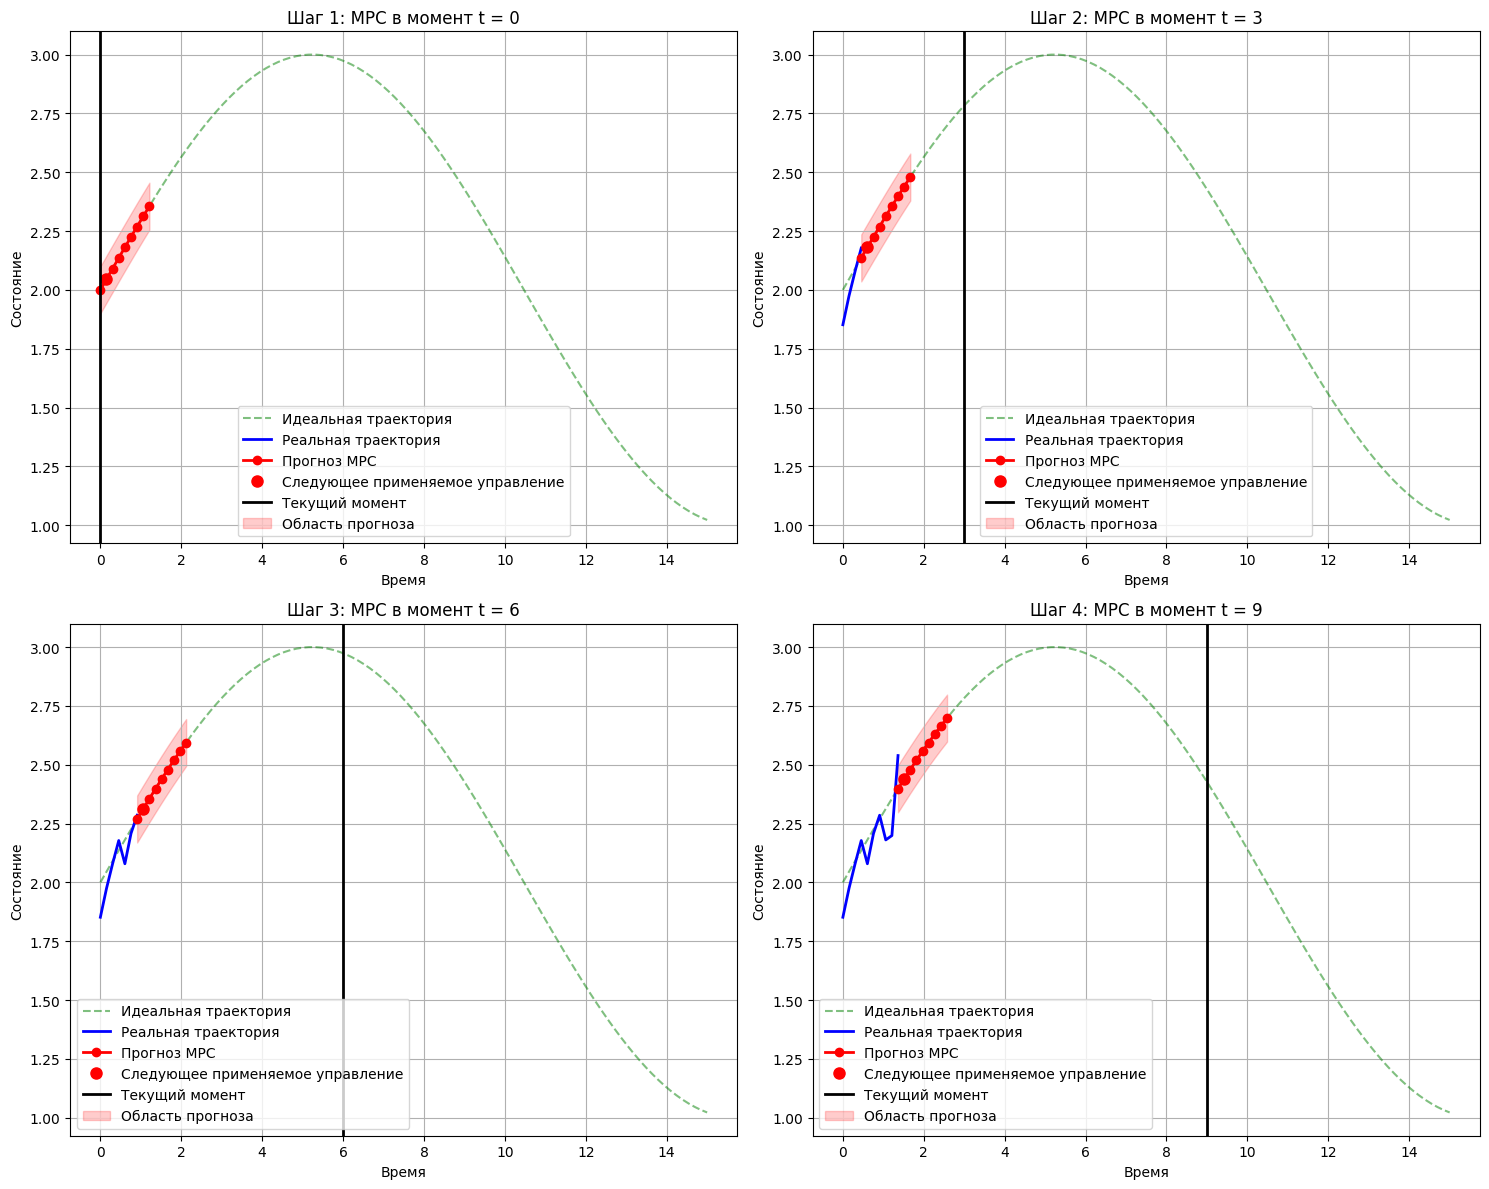


    КЛЮЧЕВЫЕ АСПЕКТЫ ПЕРЕКАТЫВАЮЩЕГОСЯ ГОРИЗОНТА:

    1. ПРЕДСКАЗУЕМОСТЬ VS НЕОПРЕДЕЛЕННОСТЬ:
       - Прогноз на горизонте N основан на текущей модели
       - Реальная траектория всегда отличается из-за возмущений
       - Перепланирование компенсирует эти отклонения

    2. ВЫЧИСЛИТЕЛЬНАЯ ЭФФЕКТИВНОСТЬ:
       - Решается задача с N шагами, а не бесконечная
       - Современные решатели могут обрабатывать N=10-50 в реальном времени

    3. ГИБКОСТЬ:
       - Можно менять целевую функцию онлайн
       - Можно адаптировать ограничения в процессе работы
    


In [66]:
def detailed_mpc_horizon_explanation():
    """Детальная визуализация принципа перекатывающегося горизонта"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Параметры симуляции
    N = 8  # горизонт прогноза
    total_steps = 4
    
    # Генерация "идеальной" и реальной траекторий
    time_ideal = np.linspace(0, 15, 100)
    trajectory_ideal = 2 + np.sin(time_ideal * 0.3)
    
    # Добавляем шум для реальной траектории
    trajectory_real = trajectory_ideal + 0.1 * np.random.randn(100)
    
    for step in range(total_steps):
        ax = axes[step // 2, step % 2]
        
        # Текущий момент
        current_time = step * 3
        current_state = trajectory_real[current_time]
        
        # Прогноз на горизонте
        forecast_start = current_time
        forecast_end = min(current_time + N, len(time_ideal) - 1)
        
        forecast_time = time_ideal[forecast_start:forecast_end + 1]
        forecast_trajectory = trajectory_ideal[forecast_start:forecast_end + 1]
        
        # Реальная траектория (прошлое)
        past_time = time_ideal[:current_time + 1]
        past_trajectory = trajectory_real[:current_time + 1]
        
        # Визуализация
        ax.plot(time_ideal, trajectory_ideal, 'g--', alpha=0.5, label='Идеальная траектория')
        ax.plot(past_time, past_trajectory, 'b-', linewidth=2, label='Реальная траектория')
        ax.plot(forecast_time, forecast_trajectory, 'r-o', linewidth=2, label='Прогноз MPC')
        
        # Выделение применяемого управления
        if step < len(forecast_time) - 1:
            ax.plot(forecast_time[1], forecast_trajectory[1], 'ro', markersize=8, 
                   label='Следующее применяемое управление')
        
        ax.axvline(x=current_time, color='k', linestyle='-', linewidth=2, label='Текущий момент')
        ax.fill_between(forecast_time, forecast_trajectory - 0.1, forecast_trajectory + 0.1, 
                       alpha=0.2, color='red', label='Область прогноза')
        
        ax.set_xlabel('Время')
        ax.set_ylabel('Состояние')
        ax.set_title(f'Шаг {step + 1}: MPC в момент t = {current_time}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Объяснение ключевых аспектов
    print("""
    КЛЮЧЕВЫЕ АСПЕКТЫ ПЕРЕКАТЫВАЮЩЕГОСЯ ГОРИЗОНТА:
    
    1. ПРЕДСКАЗУЕМОСТЬ VS НЕОПРЕДЕЛЕННОСТЬ:
       - Прогноз на горизонте N основан на текущей модели
       - Реальная траектория всегда отличается из-за возмущений
       - Перепланирование компенсирует эти отклонения
    
    2. ВЫЧИСЛИТЕЛЬНАЯ ЭФФЕКТИВНОСТЬ:
       - Решается задача с N шагами, а не бесконечная
       - Современные решатели могут обрабатывать N=10-50 в реальном времени
    
    3. ГИБКОСТЬ:
       - Можно менять целевую функцию онлайн
       - Можно адаптировать ограничения в процессе работы
    """)

detailed_mpc_horizon_explanation()

# Формальная постановка задачи
Теория:
Задача оптимизации на каждом шаге k:
$\min_{U_k} J(x_k, U_k)$

При условиях:

$x_{k+i+1|k} = f(x_{k+i|k}, u_{k+i|k}), \quad i = 0,...,N-1$

$x_{k|k} = x_k$ (начальное условие)

$g(x_{k+i|k}, u_{k+i|k}) \leq 0$ (ограничения-неравенства)

$h(x_{k+i|k}, u_{k+i|k}) = 0$ (ограничения-равенства)

$x_{k+N|k} \in X_f$ (терминальное множество)

In [67]:
class LinearMPC:
    """Простая реализация линейного MPC"""
    
    def __init__(self, A, B, Q, R, P, N, u_min=None, u_max=None, x_min=None, x_max=None):
        self.A = A  # Матрица системы
        self.B = B  # Матрица управления
        self.Q = Q  # Вес состояний
        self.R = R  # Вес управлений
        self.P = P  # Терминальный вес
        self.N = N  # Горизонт прогноза
        self.u_min = u_min
        self.u_max = u_max
        self.x_min = x_min
        self.x_max = x_max
        
        self.n = A.shape[0]
        self.m = B.shape[1]
    
    def solve(self, x0, x_ref):
        """Решает задачу MPC для текущего состояния x0 и целевого x_ref"""
        
        # Переменные оптимизации
        U = cp.Variable((self.m, self.N))
        X = cp.Variable((self.n, self.N + 1))
        
        # Ограничения и целевая функция
        constraints = [X[:, 0] == x0]
        cost = 0
        
        for k in range(self.N):
            # Динамика системы
            constraints.append(X[:, k + 1] == self.A @ X[:, k] + self.B @ U[:, k])
            
            # Целевая функция
            cost += cp.quad_form(X[:, k] - x_ref, self.Q)
            cost += cp.quad_form(U[:, k], self.R)
            
            # Ограничения на управление
            if self.u_min is not None and self.u_max is not None:
                constraints.append(U[:, k] >= self.u_min)
                constraints.append(U[:, k] <= self.u_max)
            
            # Ограничения на состояние
            if self.x_min is not None and self.x_max is not None:
                constraints.append(X[:, k] >= self.x_min)
                constraints.append(X[:, k] <= self.x_max)
        
        # Терминальная стоимость
        cost += cp.quad_form(X[:, self.N] - x_ref, self.P)
        
        # Решение задачи
        problem = cp.Problem(cp.Minimize(cost), constraints)
        problem.solve()
        
        if problem.status == cp.OPTIMAL:
            return U.value[:, 0], X.value, U.value
        else:
            raise Exception("Оптимизация не удалась")

# Пример системы (двойной интегратор)
dt = 0.1
A = np.array([[1, dt], [0, 1]])
B = np.array([[0.5 * dt**2], [dt]])

print("Матрица системы A:")
print(A)
print("\nМатрица управления B:")
print(B)

Матрица системы A:
[[1.  0.1]
 [0.  1. ]]

Матрица управления B:
[[0.005]
 [0.1  ]]


# Типы ограничений в MPC

Основные типы ограничений:

Амплитудные ограничения: $u_{min} \leq u_k \leq u_{max}$

Ограничения на скорость изменения: $|\Delta u_k| \leq \Delta u_{max}$

Ограничения на состояния: $x_{min} \leq x_k \leq x_{max}$

Смешанные ограничения: $A_ix_k + B_iu_k \leq c_i$

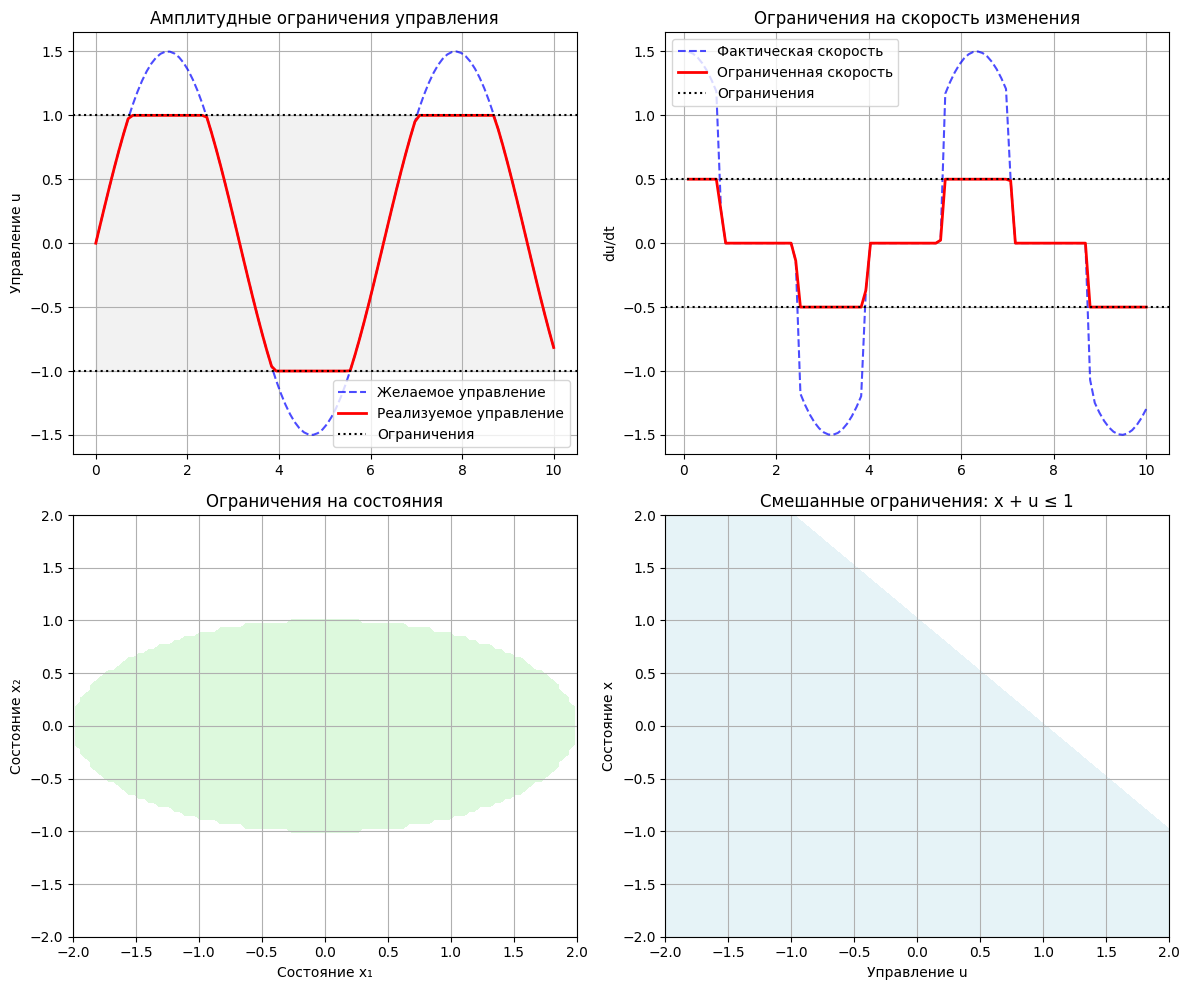

In [68]:
def plot_constraints():
    """Визуализация различных типов ограничений в MPC"""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Ограничения на амплитуду управления
    t = np.linspace(0, 10, 100)
    u = np.sin(t) * 1.5
    u_clipped = np.clip(u, -1, 1)
    
    axes[0, 0].plot(t, u, 'b--', label='Желаемое управление', alpha=0.7)
    axes[0, 0].plot(t, u_clipped, 'r-', label='Реализуемое управление', linewidth=2)
    axes[0, 0].axhline(y=1, color='k', linestyle=':', label='Ограничения')
    axes[0, 0].axhline(y=-1, color='k', linestyle=':')
    axes[0, 0].fill_between(t, -1, 1, alpha=0.1, color='gray')
    axes[0, 0].set_title('Амплитудные ограничения управления')
    axes[0, 0].set_ylabel('Управление u')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # 2. Ограничения на скорость изменения
    u_rate = np.diff(u_clipped) / np.diff(t)
    max_rate = 0.5
    u_rate_limited = np.clip(u_rate, -max_rate, max_rate)
    
    axes[0, 1].plot(t[1:], u_rate, 'b--', label='Фактическая скорость', alpha=0.7)
    axes[0, 1].plot(t[1:], u_rate_limited, 'r-', label='Ограниченная скорость', linewidth=2)
    axes[0, 1].axhline(y=max_rate, color='k', linestyle=':', label='Ограничения')
    axes[0, 1].axhline(y=-max_rate, color='k', linestyle=':')
    axes[0, 1].set_title('Ограничения на скорость изменения')
    axes[0, 1].set_ylabel('du/dt')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # 3. Ограничения на состояния
    x1 = np.linspace(-2, 2, 100)
    x2 = np.linspace(-2, 2, 100)
    X1, X2 = np.meshgrid(x1, x2)
    
    # Допустимая область (эллипс)
    feasible = (X1**2/4 + X2**2) <= 1
    
    axes[1, 0].contourf(X1, X2, feasible, levels=[0.5, 1], colors=['lightgreen'], alpha=0.3)
    axes[1, 0].contour(X1, X2, feasible, levels=[1], colors=['red'], linewidths=2)
    axes[1, 0].set_xlabel('Состояние x₁')
    axes[1, 0].set_ylabel('Состояние x₂')
    axes[1, 0].set_title('Ограничения на состояния')
    axes[1, 0].grid(True)
    
    # 4. Смешанные ограничения
    u_vals = np.linspace(-2, 2, 50)
    x_vals = np.linspace(-2, 2, 50)
    U, X = np.meshgrid(u_vals, x_vals)
    
    # Ограничение: x + u ≤ 1
    mixed_constraint = X + U <= 1
    
    axes[1, 1].contourf(U, X, mixed_constraint, levels=[0.5, 1], colors=['lightblue'], alpha=0.3)
    axes[1, 1].contour(U, X, mixed_constraint, levels=[1], colors=['blue'], linewidths=2)
    axes[1, 1].set_xlabel('Управление u')
    axes[1, 1].set_ylabel('Состояние x')
    axes[1, 1].set_title('Смешанные ограничения: x + u ≤ 1')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_constraints()

# Код 

Демонстрация концепций MPC (без реальной оптимизации)
Матрица системы A:
[[ 0.9  0.2]
 [-0.1  0.8]]
Матрица управления B:
[[0.1]
 [0.2]]


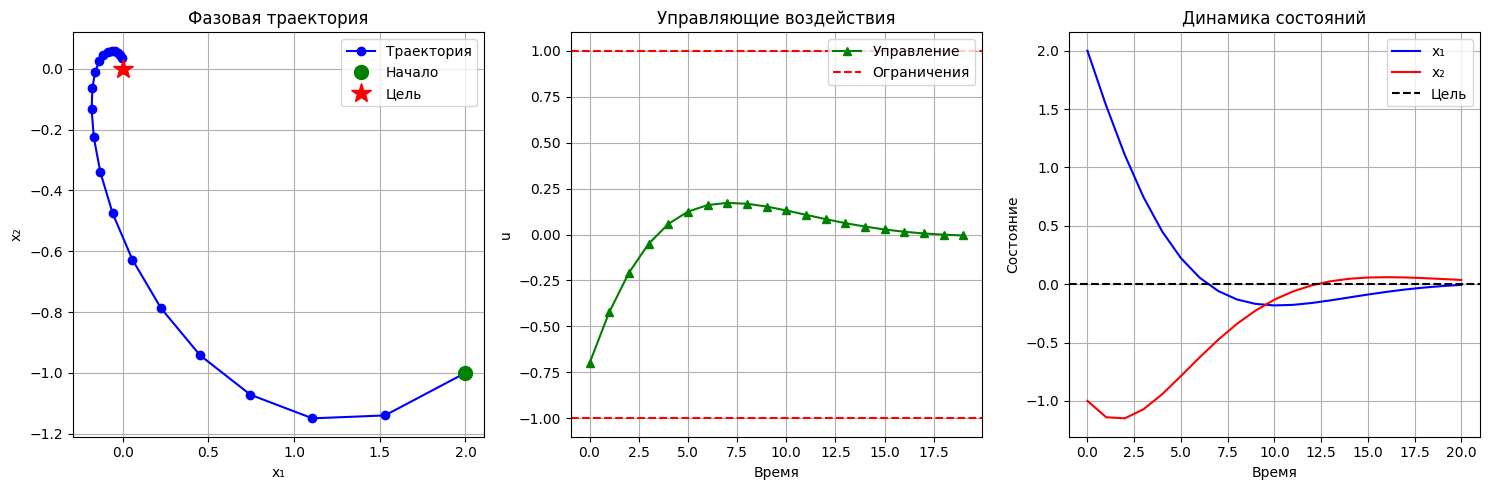

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def simple_mpc_visualization():
    """Визуализация концепций MPC без реальной оптимизации"""
    
    # Параметры системы
    A = np.array([[0.9, 0.2], [-0.1, 0.8]])
    B = np.array([[0.1], [0.2]])
    
    print("Демонстрация концепций MPC (без реальной оптимизации)")
    print("Матрица системы A:")
    print(A)
    print("Матрица управления B:")
    print(B)
    
    # Имитация работы MPC
    n_steps = 20
    x_history = np.zeros((2, n_steps + 1))
    u_history = np.zeros(n_steps)
    
    # Начальные условия
    x0 = np.array([2, -1])
    x_ref = np.array([0, 0])
    x_history[:, 0] = x0
    
    # Простая имитация (без реального MPC)
    for k in range(n_steps):
        # Простой контроллер (не MPC)
        error = x_history[:, k] - x_ref
        u_simple = -0.5 * error[0] - 0.3 * error[1]  # Простая обратная связь
        u_simple = np.clip(u_simple, -1, 1)  # Ограничения
        
        u_history[k] = u_simple
        x_history[:, k+1] = A @ x_history[:, k] + B.flatten() * u_simple
    
    # Визуализация
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(x_history[0, :], x_history[1, :], 'bo-', label='Траектория')
    plt.plot(x0[0], x0[1], 'go', markersize=10, label='Начало')
    plt.plot(x_ref[0], x_ref[1], 'r*', markersize=15, label='Цель')
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.title('Фазовая траектория')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(range(n_steps), u_history, 'g^-', label='Управление')
    plt.axhline(y=1, color='r', linestyle='--', label='Ограничения')
    plt.axhline(y=-1, color='r', linestyle='--')
    plt.xlabel('Время')
    plt.ylabel('u')
    plt.title('Управляющие воздействия')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(range(n_steps+1), x_history[0, :], 'b-', label='x₁')
    plt.plot(range(n_steps+1), x_history[1, :], 'r-', label='x₂')
    plt.axhline(y=0, color='k', linestyle='--', label='Цель')
    plt.xlabel('Время')
    plt.ylabel('Состояние')
    plt.title('Динамика состояний')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Альтернативная демонстрация
simple_mpc_visualization()

# Стабильность и теоретические аспекты
Теория:
Условия стабильности MPC:

Терминальное множество: $X_f$ такое, что:

$X_f$ инвариантен при $u = Kx$

$V(f(x, Kx)) - V(x) \leq -l(x, Kx)$ для всех $x \in X_f$

Терминальная стоимость: $V(x)$ должна удовлетворять:

$V(x) \geq l(x, Kx)$

$V(f(x, Kx)) - V(x) \leq -l(x, Kx)$

Теорема стабильности MPC:
Если выполнены условия управляемости, положительной определенности стоимости и существования терминального множества, то замкнутая система MPC устойчива.

Система управляема: True
Собственные значения системы: [0.85+0.05j 0.85-0.05j]


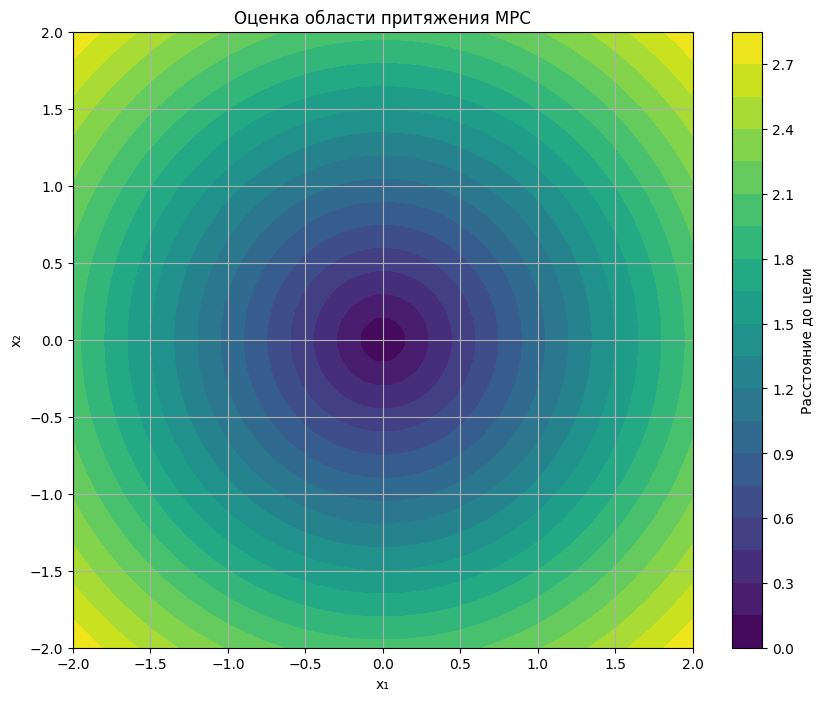

In [70]:
def stability_analysis():
    """Анализ стабильности MPC"""
    
    # Пример: проверка устойчивости замкнутой системы
    A = np.array([[0.9, 0.1], [-0.05, 0.8]])
    B = np.array([[0.1], [0.2]])
    
    # Проверка управляемости
    def check_controllability(A, B):
        n = A.shape[0]
        C = B
        for i in range(1, n):
            C = np.hstack([C, np.linalg.matrix_power(A, i) @ B])
        return np.linalg.matrix_rank(C) == n
    
    is_controllable = check_controllability(A, B)
    print(f"Система управляема: {is_controllable}")
    
    # Анализ собственных значений
    eigvals = np.linalg.eigvals(A)
    print(f"Собственные значения системы: {eigvals}")
    
    # Визуализация области притяжения
    n_points = 50
    x1 = np.linspace(-2, 2, n_points)
    x2 = np.linspace(-2, 2, n_points)
    X1, X2 = np.meshgrid(x1, x2)
    
    convergence_time = np.zeros((n_points, n_points))
    
    # Упрощенный анализ сходимости
    for i in range(n_points):
        for j in range(n_points):
            x0 = np.array([X1[i, j], X2[i, j]])
            # Простая оценка времени сходимости
            dist = np.linalg.norm(x0)
            convergence_time[i, j] = dist
    
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X1, X2, convergence_time, levels=20, cmap='viridis')
    plt.colorbar(contour, label='Расстояние до цели')
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.title('Оценка области притяжения MPC')
    plt.grid(True)
    plt.show()

stability_analysis()